# Classification of reconstructed images
Here, I am trying to modify the code so it can be used in a general way and I don't have to keep making different notebooks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import torch
import sklearn
import wandb

# Choose path depending in which device I am working with
desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Classify import classification_cnn
import confusion_matrix as cm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

# Load MNIST Data

In [3]:
%%time

# ---------------- LOAD DATA ---------------------------
# define list of parameters
SNR = 'noiseless' #noise level in dB
method = 'decoder' #"direct" #
params = {
  "dataset": f"MNIST_mura_{SNR}_reconstructed_{method}_method",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 50,
  "p": 23, # size of array (has to be prime)
  "image_size": 23,
  "kernel_size": 3,
  "SNR": SNR,
  "method": method,
  "kind": "classification",
  "suffix": f"{SNR}_reconstructed_{method}_method",#f"{SNR}dB" #_reconstructed_{method}_method",
}
params['model'] = params['kind']+'_' + params['suffix'] 
params['model_save_path'] = f'../models/{params["kind"]}/{params["model"]}.pth'

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])
wandb.config = params


CPU times: user 2.09 ms, sys: 2.26 ms, total: 4.34 ms
Wall time: 10.4 ms


In [5]:
# ---------------- define CNN and get data ----------------
model = classification_cnn(params)
train_data, eval_data, test_data, loaders = classification_cnn.load_encoded_data(model.params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 

## Train

In [ ]:
%%time
# -------------------------------- TRAIN --------------------------------
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="coded-aperture-MNIST", 
           group=model.params["kind"], 
           name=f"{model.params['model']}")

# Store values for later 
train_loss = []
val_loss = []

print("Starting training...")
# Start training
for epoch in range(params['epochs']):
    # --------------------- Training ------------------
    model.train()
    running_loss = 0.0
    for i, data in enumerate(loaders['train']):
        # get the inputs; data is a list of [encoded image, original image, digit label, noise level]
        # img_batch, _, digit_batch, _ = data
        img_batch, _, digit_batch = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(img_batch)
        loss = criterion(outputs, digit_batch)
        loss.backward()
        optimizer.step()
    

        running_loss += loss.item()
        
    # Average loss over entire dataset
    running_loss /= len(loaders['train'].dataset)
    train_loss.append(running_loss)
    
    # --------------------- Validation ------------------
    model.eval()
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(loaders['eval']):
            # vinputs, _, vdigits, _ = vdata
            vinputs, _, vdigits = vdata
            voutputs = model(vinputs)
            vloss = criterion(voutputs, vdigits)
            running_vloss += vloss
        running_vloss/= len(loaders['eval'].dataset)
        val_loss.append(running_vloss) 
        
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f} | Val_loss: {running_vloss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, "val_loss": running_vloss})
print('Finished Training')

# Save model
wandb.finish()
print(f"Model will be saved in {model.params['model_save_path']}")
torch.save(model.state_dict(), model.params['model_save_path'])
print("Model saved")

Starting training...
Epoch 1 | Loss: 0.0052849 | Val_loss: 0.0016716
Epoch 2 | Loss: 0.0013969 | Val_loss: 0.0011646
Epoch 3 | Loss: 0.0008878 | Val_loss: 0.0007364
Epoch 4 | Loss: 0.0006543 | Val_loss: 0.0007490
Epoch 5 | Loss: 0.0005191 | Val_loss: 0.0005913
Epoch 6 | Loss: 0.0004316 | Val_loss: 0.0005344
Epoch 7 | Loss: 0.0003853 | Val_loss: 0.0004389
Epoch 8 | Loss: 0.0003436 | Val_loss: 0.0005881
Epoch 9 | Loss: 0.0003056 | Val_loss: 0.0005507
Epoch 10 | Loss: 0.0002644 | Val_loss: 0.0005432
Epoch 11 | Loss: 0.0002421 | Val_loss: 0.0004531
Epoch 12 | Loss: 0.0002113 | Val_loss: 0.0004803
Epoch 13 | Loss: 0.0001826 | Val_loss: 0.0005132
Epoch 14 | Loss: 0.0001867 | Val_loss: 0.0005449
Epoch 15 | Loss: 0.0001765 | Val_loss: 0.0005382
Epoch 16 | Loss: 0.0001389 | Val_loss: 0.0005799
Epoch 17 | Loss: 0.0001375 | Val_loss: 0.0003859
Epoch 18 | Loss: 0.0001169 | Val_loss: 0.0005835
Epoch 19 | Loss: 0.0001198 | Val_loss: 0.0005246
Epoch 20 | Loss: 0.0001211 | Val_loss: 0.0006359
Epoch 21

In [12]:
#----------------------------- Save The Losses -----------------------------
print("Saving training and validation loss")
import pickle
with open(path+f'metrics/{params["kind"]}/train_loss_{params["model"]}.pkl','wb') as fp:
    pickle.dump(train_loss, fp)
with open(path+f'metrics/{params["kind"]}/validation_train_loss_{params["model"]}.pkl','wb') as fp:
    pickle.dump(val_loss, fp)

Saving training and validation loss


## Evaluate

In [7]:
# Load model if one is not loaded already
model.load_state_dict(torch.load(params['model_save_path']))

<All keys matched successfully>

### ALL test set

In [14]:
#----------------------------- Evaluate Test set -----------------------------

# Initialize variables
correct = 0
total = 0
incorrect_examples = []
predicted_all = []
labels_all = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in loaders['test']:
        if len(data) == 3:
            
            images, _, labels = data
        else:
            # get images and labels from test set
            images, _, labels, _ = data
    
        # calculate outputs by running images through the network (done in batches)
        outputs = model(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Save misclassifications
        idxs_mask = torch.nonzero(predicted != labels) #((predicted == labels) == False).nonzero()
        for single_sample in idxs_mask:
            incorrect_examples.append([np.squeeze(images[single_sample].numpy()), 
                                       labels[single_sample].numpy()[0], 
                                       predicted[single_sample].numpy()[0]])
        predicted_all.append(predicted.tolist())
        labels_all.append(labels.tolist())

print(f'Accuracy of the model {params["model"]} on the {total} test images: {100 * correct / total} %')

predicted_all = list(np.concatenate(predicted_all).flat) 
labels_all = list(np.concatenate(labels_all).flat) 

Accuracy of the model classification_noiseless_reconstructed_decoder_method on the 7000 test images: 99.28571428571429 %


# Plots

In [15]:
#----------------------------- PLOTTING -----------------------------
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,12],
})

FIG_FOLDER = path + f'figs/{params["kind"]}/{params["method"]}_method/'
title_size = 30
label_size = 28
tick_size = 24

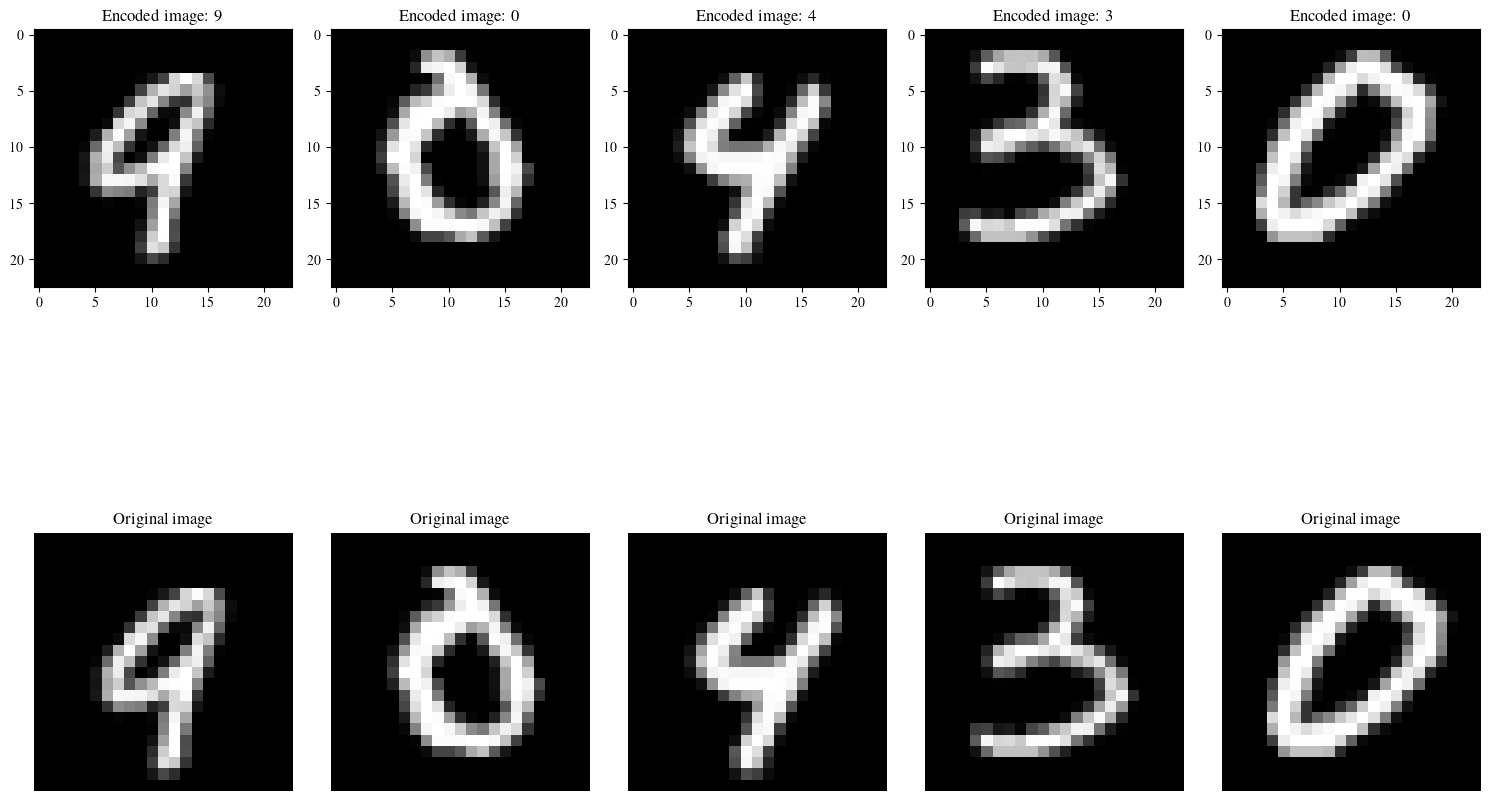

In [16]:
# Printing 25 random images from the training dataset
random_samples = np.random.randint(1, len(train_data), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    plt.imshow(train_data[idx][0][0].numpy(), cmap='gray')
    #plt.colorbar()
    plt.title(f'Encoded image: {train_data[idx][2]}')
    plt.subplot(2, 5, count + 6)
    plt.imshow(train_data[idx][1][0].numpy(), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
#plt.savefig("../figs/encoded_original_examples.png")
plt.show()

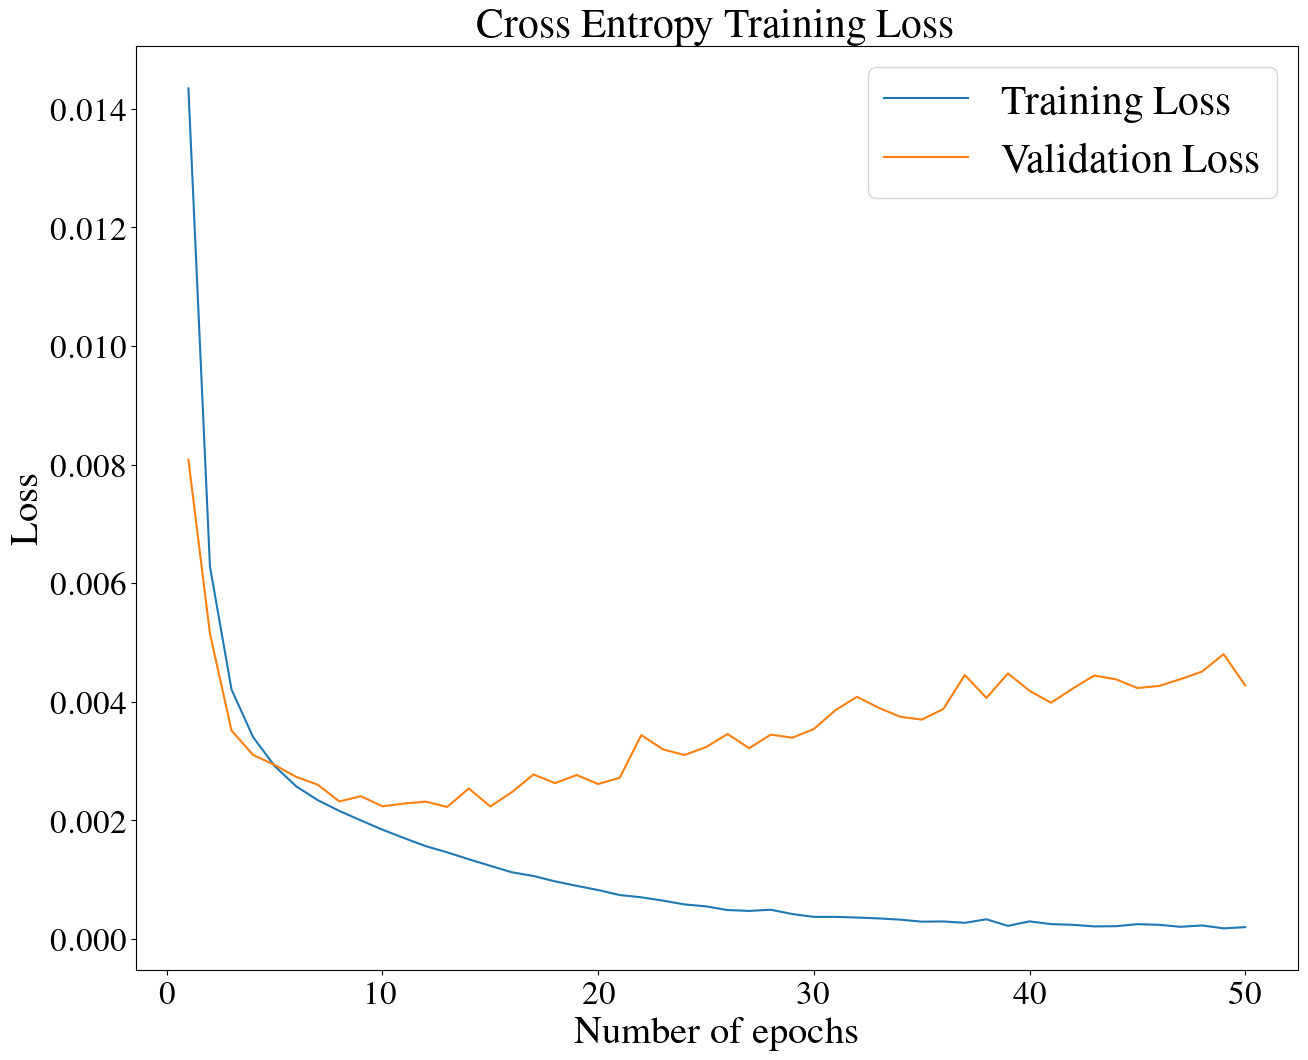

In [11]:
# --- Plot training and val loss
fig, axs = plt.subplots(1,1)
axs.plot(range(1,params['epochs']+1), train_loss, label="Training Loss")
axs.plot(range(1,params['epochs']+1), val_loss, label="Validation Loss")


axs.set_xlabel("Number of epochs", fontsize = label_size)
axs.set_ylabel("Loss", fontsize = label_size)
axs.set_title("Cross Entropy Training Loss", fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
axs.legend(fontsize=title_size)
plt.savefig(FIG_FOLDER + f'training_loss_{params["model"]}.png')
plt.show()

## Confusion Matrix

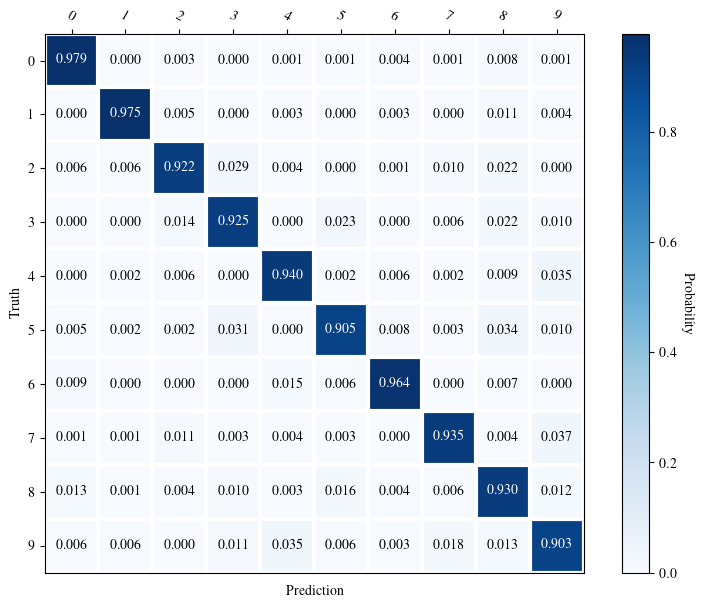

In [12]:
# --- Confusion Matrix
# Converting list of tensors to list of integers
preds = [pred for pred in predicted_all]
truths = [tru for tru in labels_all]

con_mat = sklearn.metrics.confusion_matrix(truths,preds,normalize='true')
axlabels= [ str(num) for num in np.arange(10)]

fig, ax = plt.subplots(figsize=(10,7))
im, cbar = cm.heatmap(con_mat, axlabels, axlabels, ax=ax,cmap = 'Blues', cbarlabel="Probability")
plt.ylabel("Truth")
plt.xlabel("Prediction")
texts = cm.annotate_heatmap(im, valfmt="{x:.3f}")
fig1 = plt.gcf()
fig1.savefig(FIG_FOLDER + f'conf_mat_{params["model"]}.png')

# Missclassifications

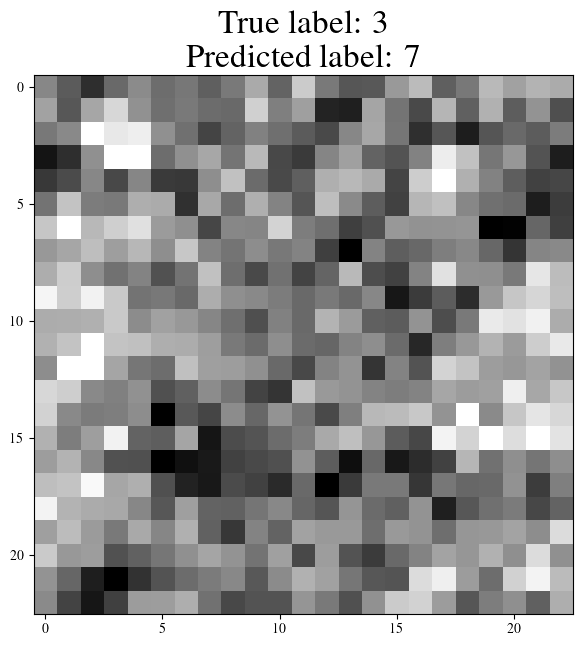

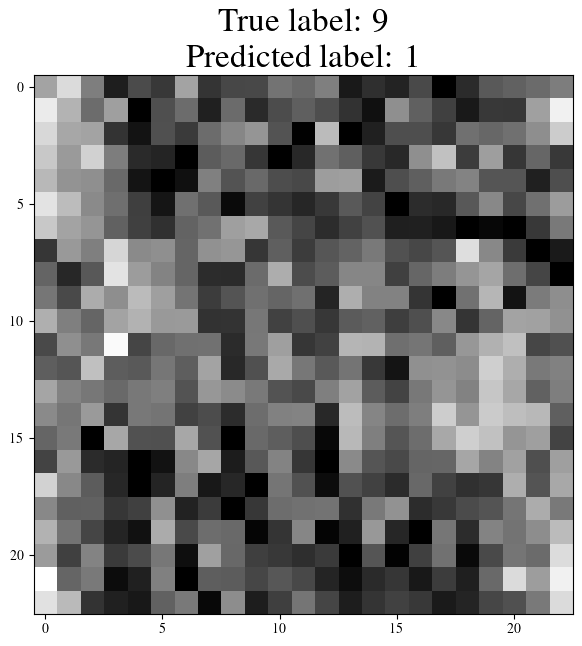

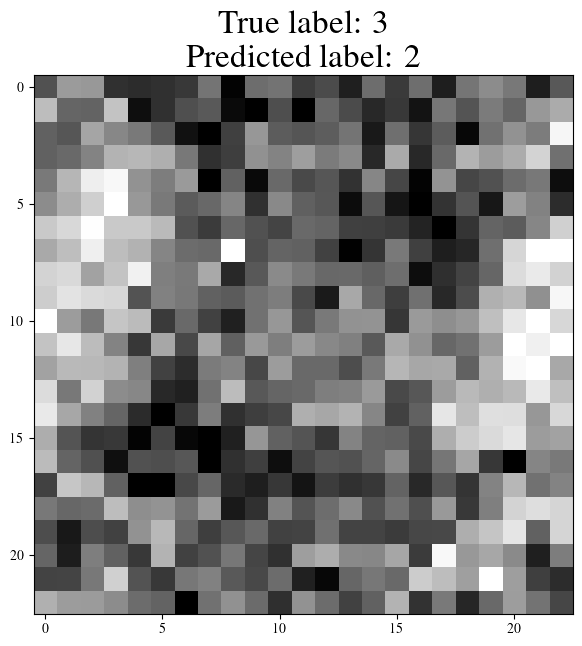

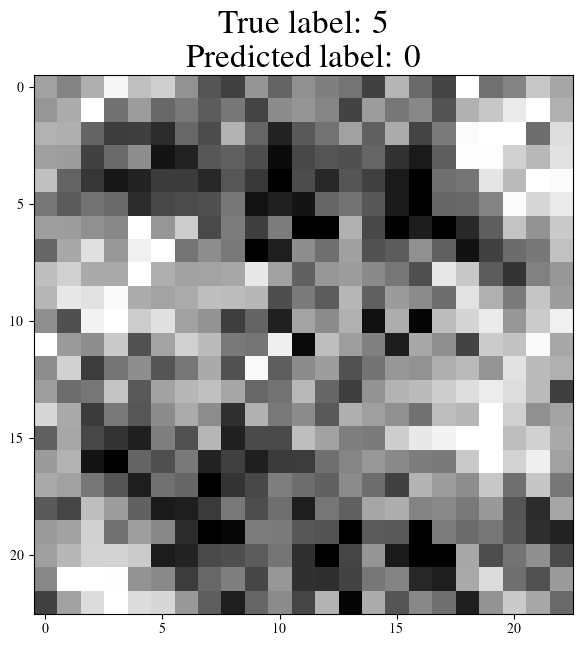

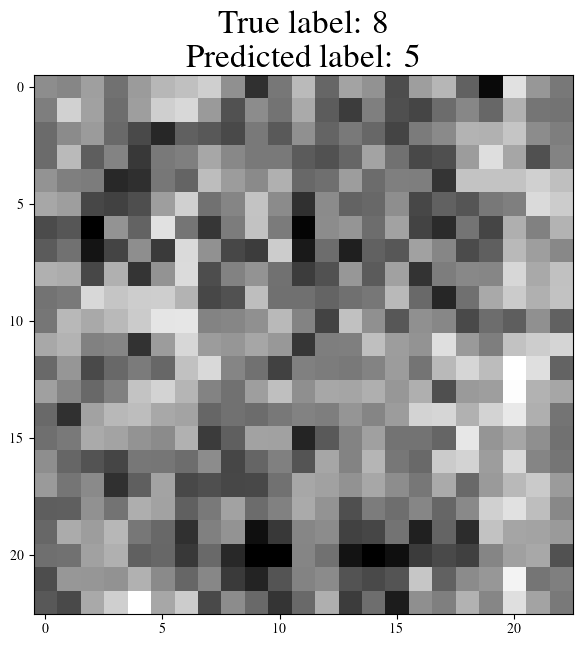

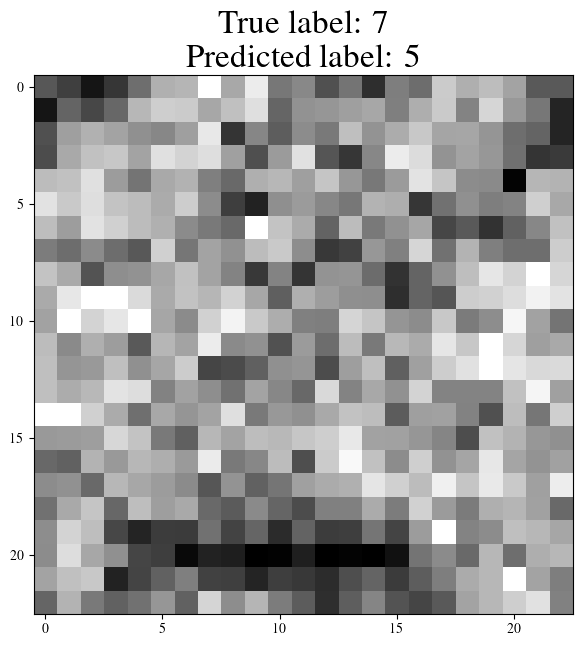

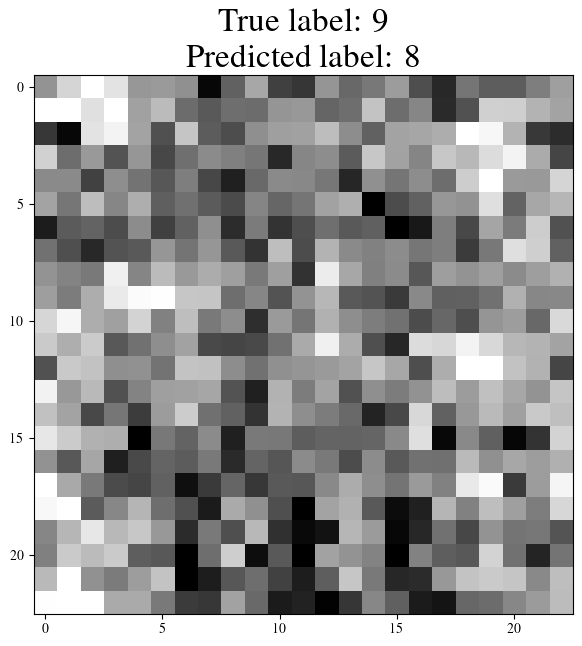

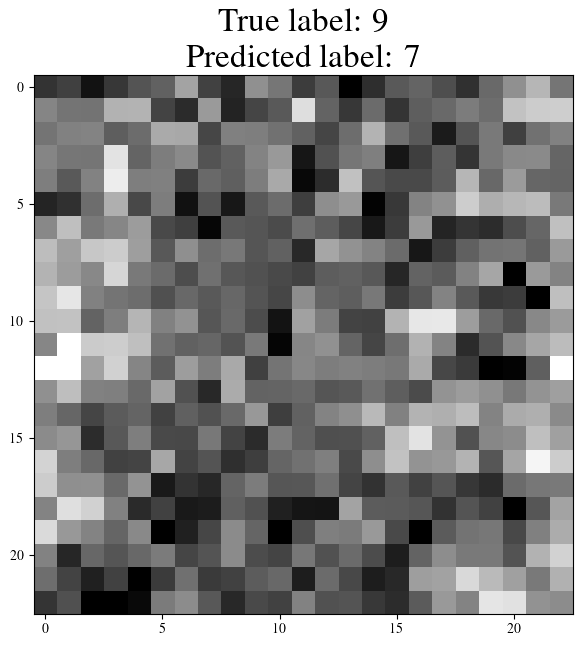

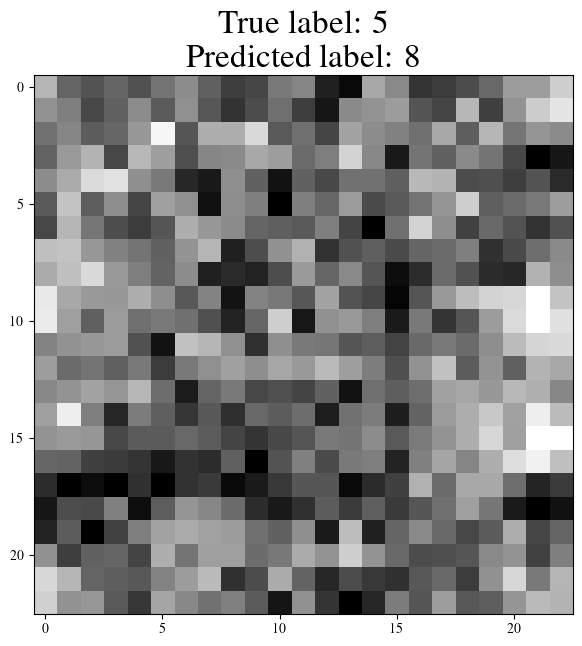

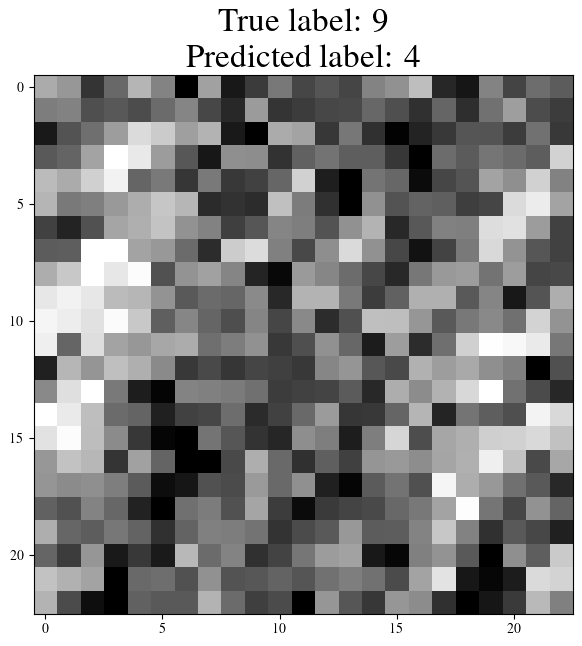

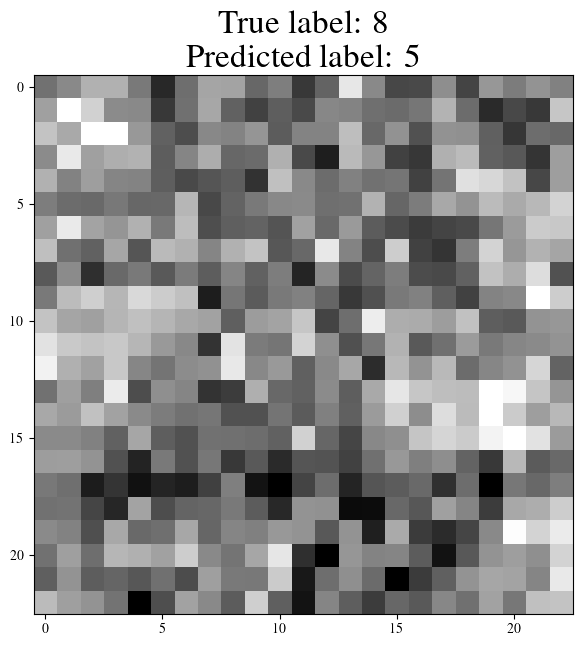

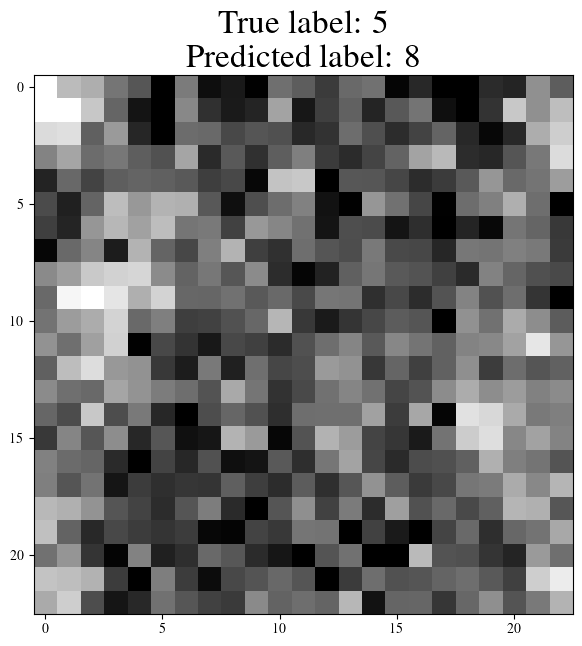

In [13]:
#index = 1
#FIG_FOLDER = "/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/slides_coded_aperture/images/"

cmap = 'gray'
for index in range(30,50):#len(incorrect_examples)):
    img = np.squeeze(incorrect_examples[index][0])
    #true_img = mura.FFT_convolve(img, G)
    true_lab = incorrect_examples[index][1]
    pred_lab = incorrect_examples[index][2]

    if true_lab in [5,7,3,8,9]:
        #fig, axs = plt.subplots(2,1, figsize=(5,12))
        #axs = axs.ravel()
        fig, axs = plt.subplots(1,1, figsize=(7,7))
        #axs[0].imshow(true_img, cmap=cmap)
        axs.imshow(img, cmap=cmap)
        axs.set_title(f"True label: {true_lab}\nPredicted label: {pred_lab}", fontsize=24)
        #axs[0].set_title(f"Original Image", fontsize=24)
        #fig.savefig(FIG_FOLDER + f'misclass_{params["model"]}_{index}.png')
        plt.show() 

Misclassifications stats
9    0.160465
5    0.134884
2    0.130233
3    0.120930
8    0.111628
7    0.109302
4    0.093023
6    0.058140
1    0.046512
0    0.034884
Name: label, dtype: float64


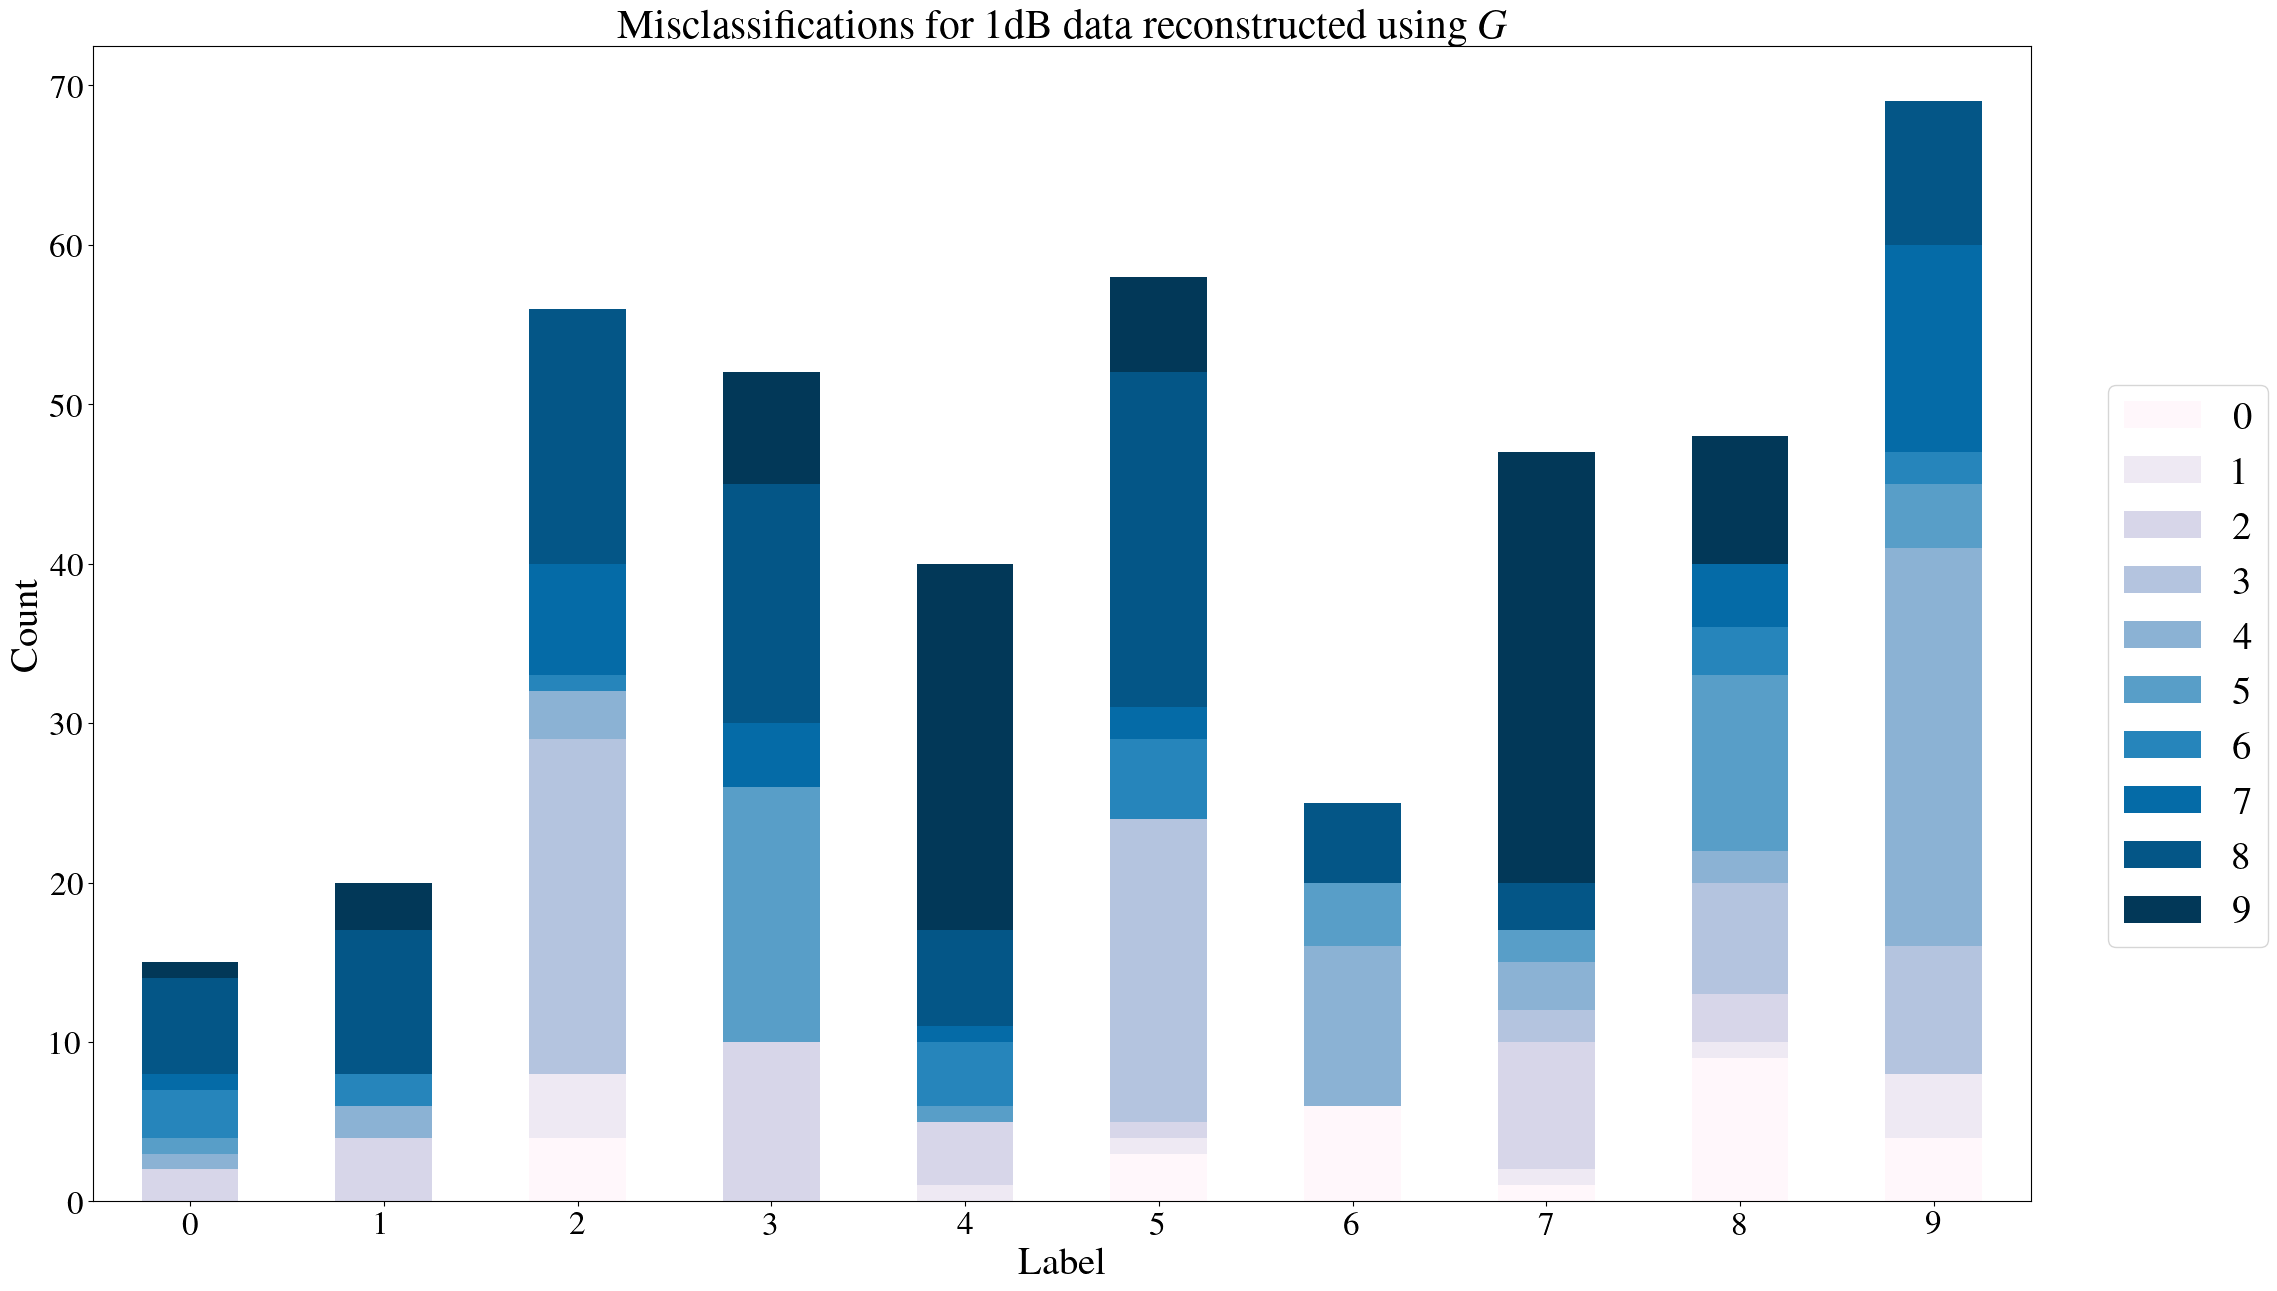

prediction  0  1   2   3   4   5  6   7   8   9
label                                          
0           0  0   2   0   1   1  3   1   6   1
1           0  0   4   0   2   0  2   0   9   3
2           4  4   0  21   3   0  1   7  16   0
3           0  0  10   0   0  16  0   4  15   7
4           0  1   4   0   0   1  4   1   6  23
5           3  1   1  19   0   0  5   2  21   6
6           6  0   0   0  10   4  0   0   5   0
7           1  1   8   2   3   2  0   0   3  27
8           9  1   3   7   2  11  3   4   0   8
9           4  4   0   8  25   4  2  13   9   0


In [14]:
# Save dataframe with misclassifications
df = pd.DataFrame(incorrect_examples, columns=['image_array', 'label', 'prediction'])
print("Misclassifications stats")
print(df.label.value_counts(normalize=True))

plt.rcParams.update({"figure.figsize" : [25,15]})
crosstab_misclass = pd.crosstab(df.label, df.prediction, margins=False)
crosstab_misclass.plot(kind="bar", stacked=True, rot=0, cmap="PuBu")
plt.ylabel("Count", fontsize=label_size)
plt.xlabel("Label", fontsize=label_size)
plt.title(f"Misclassifications for {params['SNR']}dB data reconstructed using $G$", fontsize=title_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=label_size,loc=(1.04, 0.22))
plt.savefig(FIG_FOLDER + f'misclass_{params["model"]}.png')
plt.show()
print(crosstab_misclass)

## Class-specific accuracy

In [15]:
classes = [i for i in range(10)]
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in loaders['test']:
        _, _, images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[int(label.numpy())] += 1
            total_pred[int(label.numpy())] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5d} is {accuracy:.3f} %')

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [8, 1, 3, 3], but got 1-dimensional input of size [100] instead